In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

In [3]:
def plot_fcst(fcst, train=None, test=None):
    fcst = fcst.set_index("ds")
    ax = fcst.yhat.plot()
    lower = fcst.yhat_lower
    upper = fcst.yhat_upper
    plt.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)
    if train is not None:
        train.plot(style="k.")
    if test is not None:
        test.plot(style="r.")

In [4]:
plt.rcParams["figure.figsize"] = (14,4)

In [57]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])
data = data.drop(columns=["Unnamed: 0", "nro factura"])

In [6]:
#u_producto = data.groupby(["tiempo", "producto"])["u pedidas"].sum().unstack().asfreq("D").fillna(0)

In [79]:
u_producto = pd.pivot_table(data, values="u pedidas", index="tiempo", columns="producto", aggfunc="sum").asfreq("D")

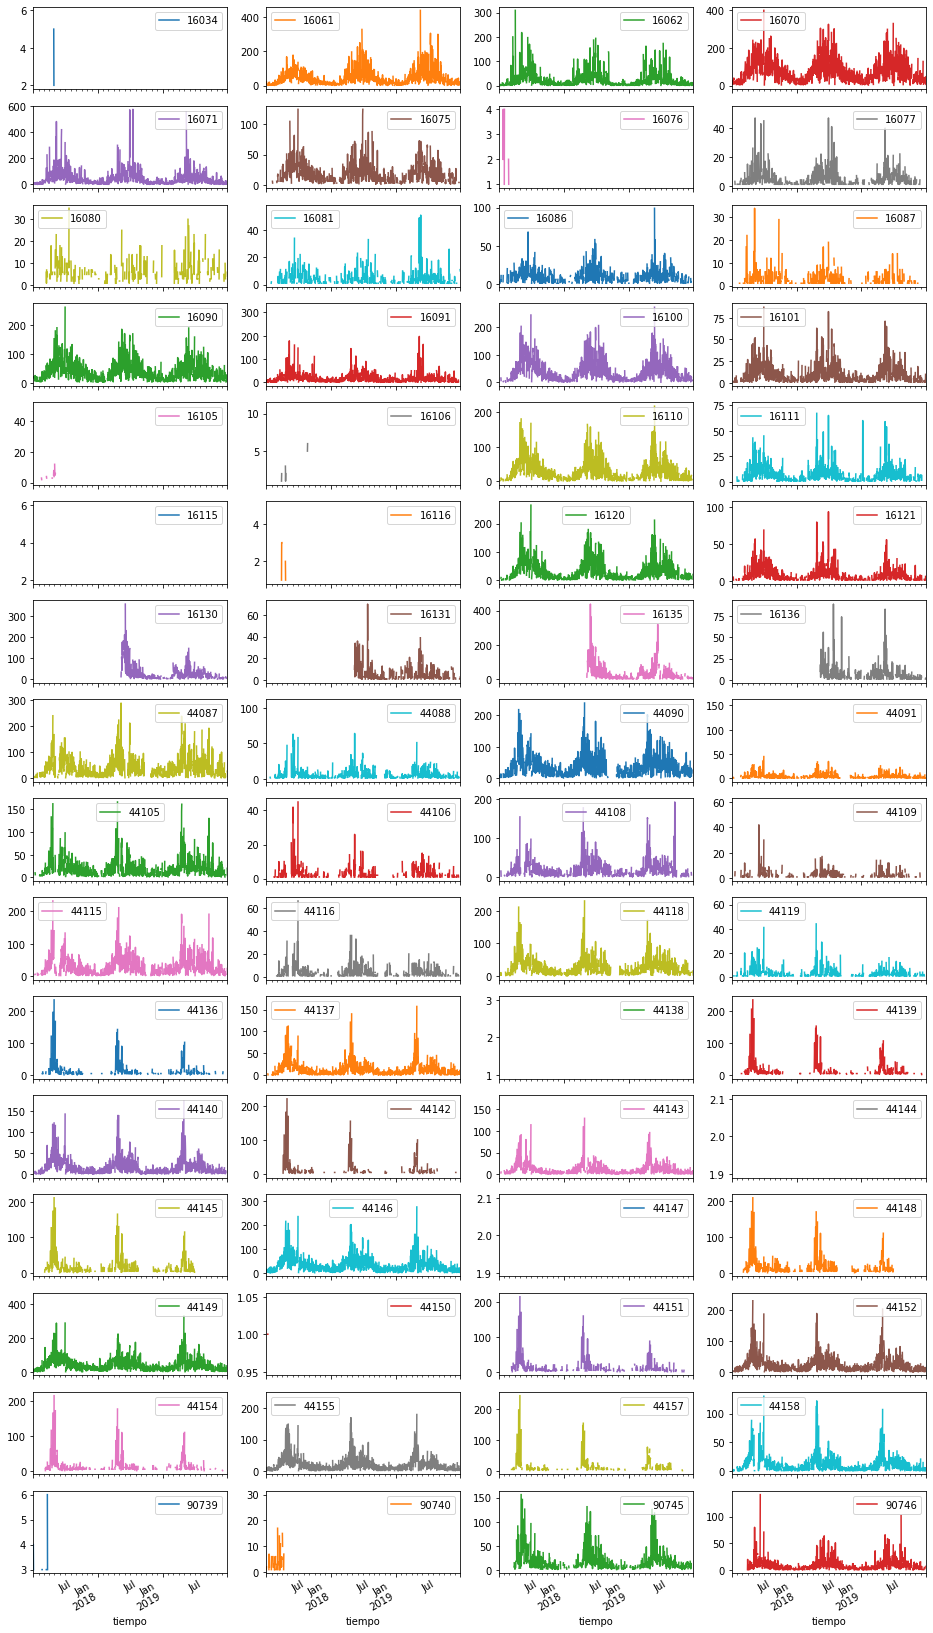

In [80]:
plot_grid(u_producto, 4, figsize=(16,32))

In [83]:
amount_info = (u_producto.notna()).sum() / len(u_producto)
T = 0.5
forecastable = (amount_info > T)

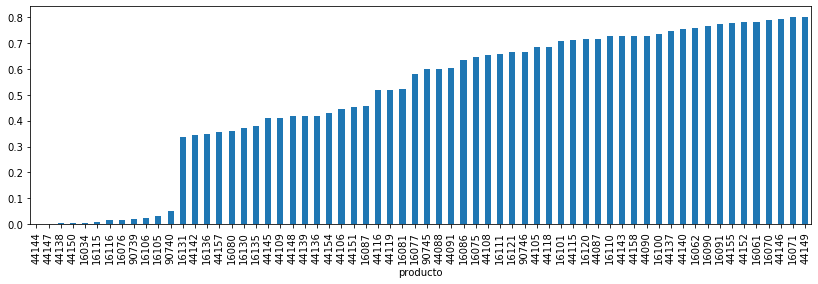

In [84]:
amount_info.sort_values().plot(kind="bar")

In [85]:
forecastable = u_producto.loc[:, forecastable]

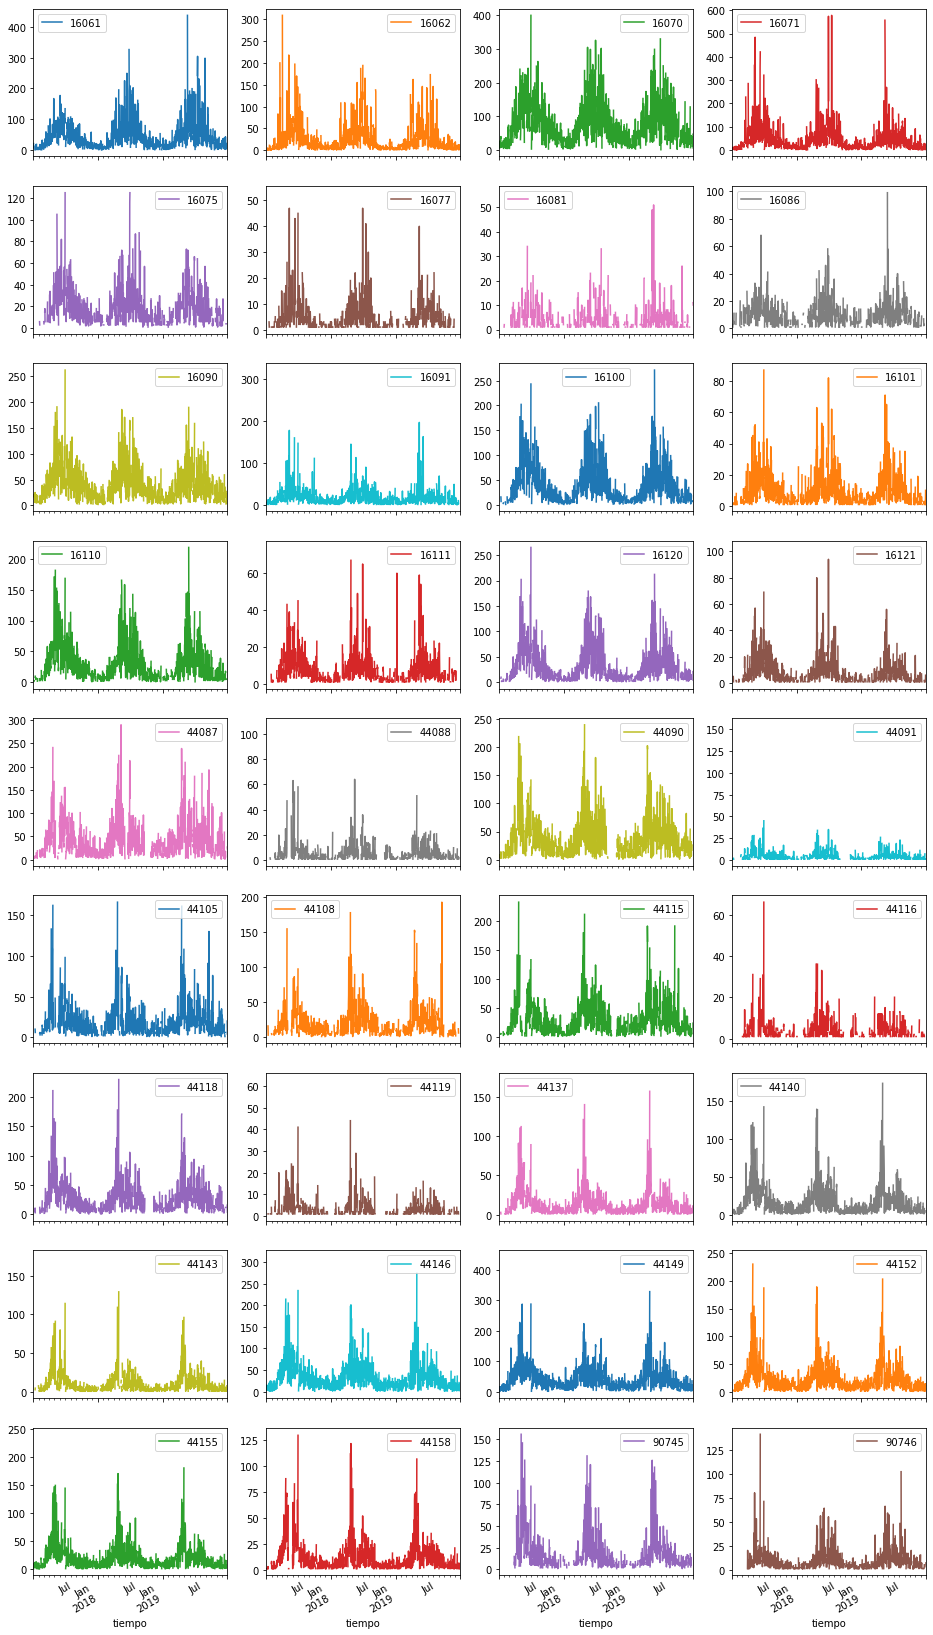

In [86]:
plot_grid(forecastable, 4, (16,32))

# Prophet

In [87]:
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

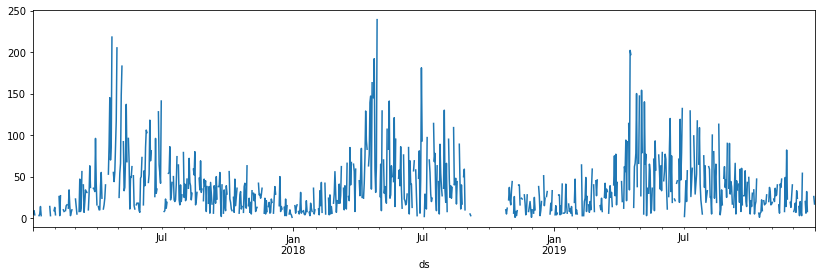

In [88]:
target = forecastable[44090].copy()
target.index.name = "ds"
target.name = "y"
target.plot()

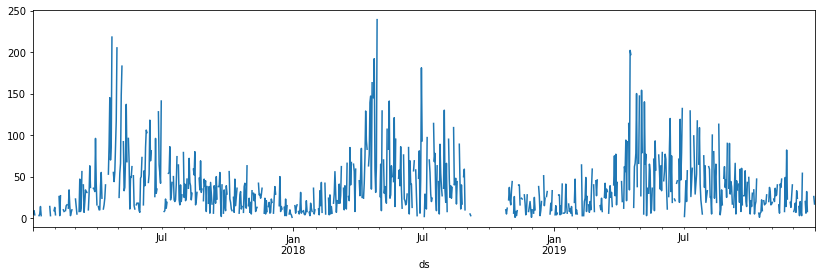

In [89]:
rolling_mean = target.rolling(window=7).mean()
target.plot()
rolling_mean.plot();

In [90]:
target_filled = target.copy()
target_filled[target == 0] = rolling_mean[target == 0]

In [91]:
target = target[target != 0]

In [92]:
train, test = target[:"2018-12-31"], target["2019-01-01":]

## Multiplicative

In [23]:
m = Prophet(seasonality_mode="multiplicative", 
            yearly_seasonality=5, 
            weekly_seasonality=False, 
            daily_seasonality=False, 
            interval_width=0.8, 
            mcmc_samples=300)
m.fit(train.reset_index());
future = m.make_future_dataframe(365, freq="D")
fcst = m.predict(future)
#fcst = fcst.set_index("ds")

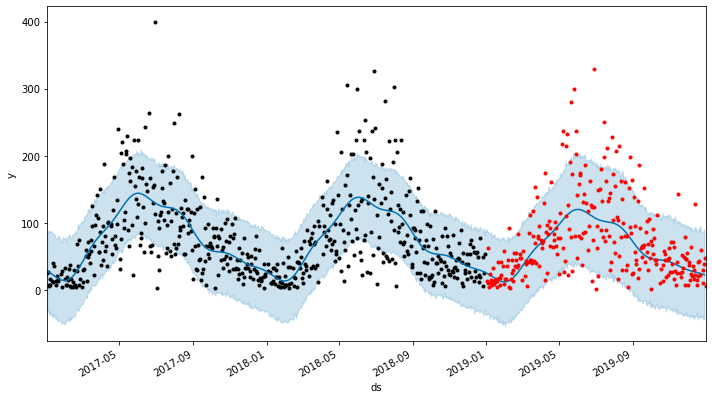

In [24]:
m.plot(fcst);
test.plot(style="r.")

## Additive without log

In [27]:
m = Prophet(seasonality_mode="additive", 
            yearly_seasonality=5, 
            weekly_seasonality=False, 
            daily_seasonality=False, 
            interval_width=0.8, 
            mcmc_samples=300,
            )
m.fit(train.reset_index());
future = m.make_future_dataframe(365, freq="D")
fcst = m.predict(future)

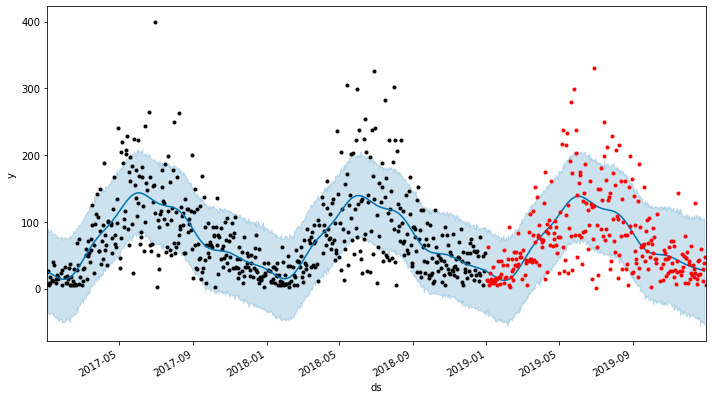

In [28]:
m.plot(fcst)
test.plot(style="r.");

## Additive with log

In [29]:
train_log = np.log(train + 1)

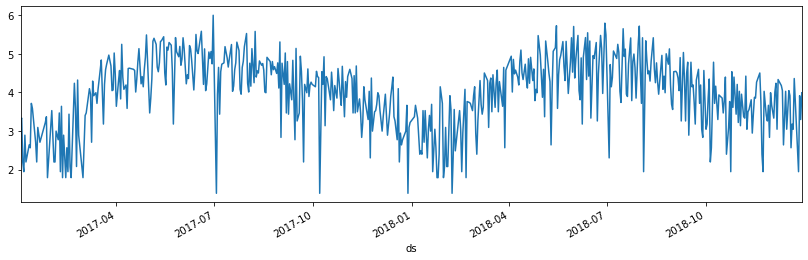

In [30]:
train_log.plot()

In [31]:
m = Prophet(seasonality_mode="additive", 
            yearly_seasonality=10, 
            weekly_seasonality=False, 
            daily_seasonality=False, 
            interval_width=0.8, 
            mcmc_samples=0,
            )
m.fit(train_log.reset_index());
future = m.make_future_dataframe(365, freq="D")
fcst_log = m.predict(future)
#fcst = fcst.set_index("ds")

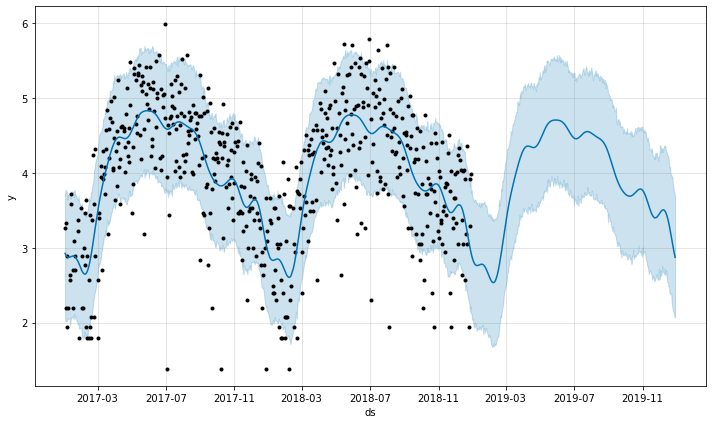

In [32]:
m.plot(fcst_log);

In [33]:
fcst = fcst_log.copy()
fcst.loc[:, ["yhat", "yhat_lower", "yhat_upper"]] = np.exp(fcst.loc[:, ["yhat", "yhat_lower", "yhat_upper"]])

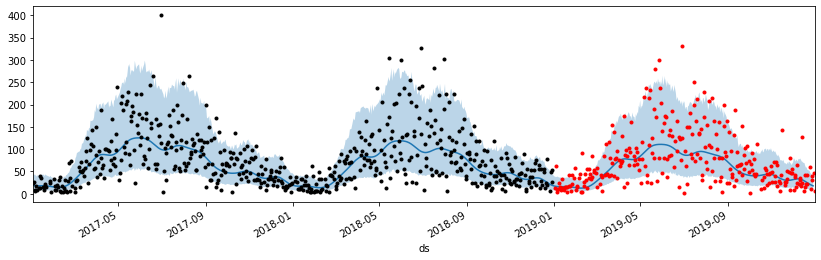

In [34]:
plot_fcst(fcst, train, test)

## Additive with Box-Cox

In [94]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [99]:
train_boxcox, lmbda = boxcox(train.dropna())
train_boxcox = pd.Series(train_boxcox, index=train.dropna().index, name="y")

In [38]:
lmbda

0.26734965457856197

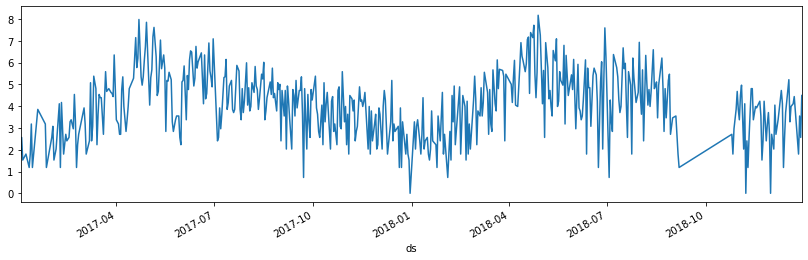

In [100]:
train_boxcox.plot()

In [101]:
m = Prophet(seasonality_mode="additive", 
            yearly_seasonality=10, 
            weekly_seasonality=False, 
            daily_seasonality=False, 
            interval_width=0.8, 
            mcmc_samples=0,
            )
m.fit(train_boxcox.reset_index());
future = m.make_future_dataframe(365, freq="D")
fcst_boxcox = m.predict(future)
#fcst = fcst.set_index("ds")

In [102]:
fcst = fcst_boxcox.copy()
fcst.loc[:, ["yhat", "yhat_lower", "yhat_upper"]] = inv_boxcox(fcst_boxcox.loc[:, ["yhat", "yhat_lower", "yhat_upper"]], lmbda)

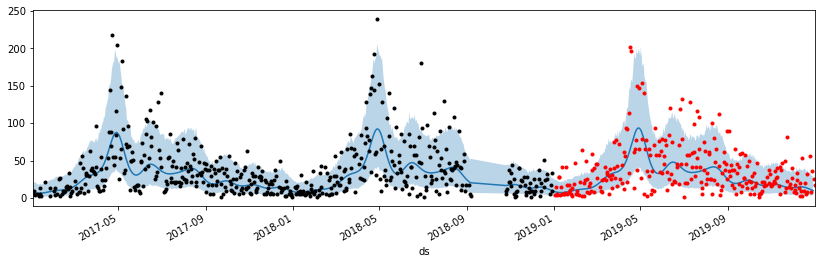

In [103]:
plot_fcst(fcst, train, test)